## Assesing generalization capabilities of the model

How well the model trained on particular datasets can predict on others.

* [Datasets](#Datasets)
* [Metrics](#Metrics)
* [Train and test pipelines](#Train-and-test-pipelines)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Dataset-bypass)
* [Conclusion](#Conclusion)

### Datasets
All 3 avaliable [datasets](https://github.com/gazprom-neft/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

### Metrics
Mean absolute error between predicted picking and target.

In [1]:
import sys
import numpy as np
from matplotlib import colors as mcolors

sys.path.append('../../..')

from seismicpro.src import SeismicDataset, FieldIndex, TraceIndex
from seismicpro.batchflow import Pipeline, B, V, C, W
from seismicpro.batchflow.models.torch import UNet
from seismicpro.batchflow.utils import plot_results_by_config, show_research, print_results
from seismicpro.batchflow.research import Research, Results, Option, KV, RP, REU, RI

from datasets.paths import *

Global constants for research

In [2]:
B_SIZE = 512
NUM_ITERS = 50000                                # number of iterations to train each model for
N_REPS = 3                                      # number of times to repeat each model train
RESEARCH_NAME = 'research3x3'                   # name of Research object
DEVICES = [0, 1, 2, 3, 4, 5, 6, 7]              # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 200

Avaliable datasets.

In [3]:
index1 = FieldIndex(name='raw', path=pal_raw, markup_path=pal_markup)
index2 = FieldIndex(name='raw', path=wz_raw, markup_path=wz_markup)
index3 = FieldIndex(name='raw', path=vor_raw, markup_path=vor_markup)

Split indices.   
Datasets for validation are stored in the list `test_data`

In [4]:
test_data = []
for index in [index1, index2, index3]:
    index.split(shuffle=42)
    test_data.append(SeismicDataset(TraceIndex(index.test)))

Model config.

In [5]:
config = {
    'inputs': {'masks': dict(classes=2)},
    'body/encoder/blocks/filters': [16, 32, 64, 128, 256],
    'body/decoder/blocks/filters': [16, 32, 64, 128, 256][::-1],
    'body/embedding/filters': 512,
    'optimizer': C('optimizer'),
    'optimizer': ('Adam', {'lr': 0.001}),
    "decay": dict(name='exp', gamma=0.1),
    "n_iters": 30000,
    'device': C('device'),
}

### Train-and-test-pipelines

In [6]:
train_pipeline = (Pipeline()
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', [])
                      .load(components='raw', fmt='segy', tslice=slice(0, 1000))
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss',mode='w'))
                      .run_later(B_SIZE, n_epochs=None, drop_last=True, shuffle=42)
                 ) << C('train_data')

Test pipeline executed on each dataset in `test_data`.

In [8]:
def test_pipeline(test_data, import_from):
    test_pipeline = (test_data.p
                      .import_model('my_model', import_from)
                      .init_variable('true', [])
                      .init_variable('predictions', [])
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask', src_traces='raw')
                      .update(V('true', mode='a'), B('mask'))
                      .add_components(components='predictions')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .predict_model('my_model', B('raw'), fetches='predictions',
                                     save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .update(V('predictions', mode='a'), B('predictions'))
                      .run_later(1000, n_epochs=1, drop_last=False, shuffle=False))
    return test_pipeline 

In [9]:
def mae(iteration, import_from, test_data):
    res = []
    for data in test_data:
        pipeline = test_pipeline(data, import_from)
        pipeline.run()
        pred = np.hstack(np.concatenate(pipeline.v('predictions')))
        true = np.argmax(np.stack(np.concatenate(pipeline.v('true'))), axis=1)
        res.append(np.mean(np.abs(true - pred)))
    return tuple(res)

Research domain. Consist of all possible combinations of 3 datasets.

In [10]:
domain = Option('train_data', [KV(SeismicDataset(TraceIndex(index1.train)), 'PAL'), 
                               KV(SeismicDataset(TraceIndex(index2.train)), 'WZ'), 
                               KV(SeismicDataset(TraceIndex(index3.train)), 'VOR'), 
                               KV(SeismicDataset(TraceIndex(index1.train + index2.train)),
                                  'PAL + WZ'), 
                               KV(SeismicDataset(TraceIndex(index1.train + index3.train)),
                                  'PAL + VOR'), 
                               KV(SeismicDataset(TraceIndex(index2.train + index3.train)),
                                  'WZ + VOR'), 
                               KV(SeismicDataset(TraceIndex(index1.train + index2.train + index3.train)), 
                                  'PAL + WZ + VOR')])

Research object.

In [11]:
research = (Research()
    .init_domain(domain, n_reps=N_REPS)
    .add_pipeline(train_pipeline, variables='loss', name='train_ppl', logging=True)
    .add_callable(mae, returns=['PAL', 'WZ', 'VOR'], name='test_mae', execute=TEST_FREQUENCY,  
                  iteration=RI(), import_from=RP('train_ppl'), test_data=test_data)
)

Run the research.

In [ ]:
!rm -r $RESEARCH_NAME

research.run(NUM_ITERS, workers=WORKERS, name=RESEARCH_NAME, devices=DEVICES, bar=True)

Research research3x3 is starting...


Domain updated: 0:  19%|█▉        | 198206/1050000.0 [2:01:19<8:41:25, 27.23it/s]

### Results

In [15]:
results = Results(path=RESEARCH_NAME, concat_config=True)

Loss functions vs a number of iterations for each model:

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


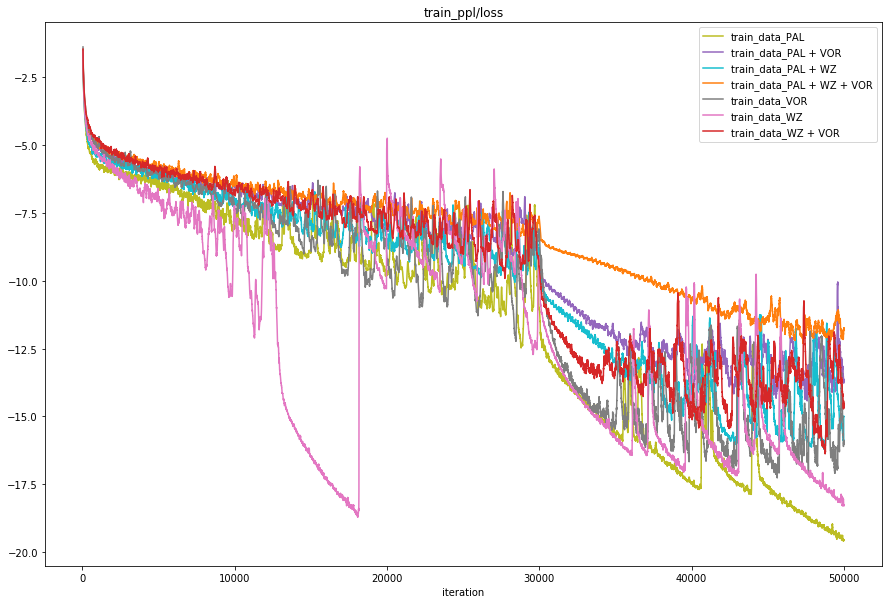

In [17]:
show_research(results.df, layout=['train_ppl/loss'], average_repetitions=True, scale=(15, 10),
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=True, rolling_window=50)

Validation metrics for each dataset.

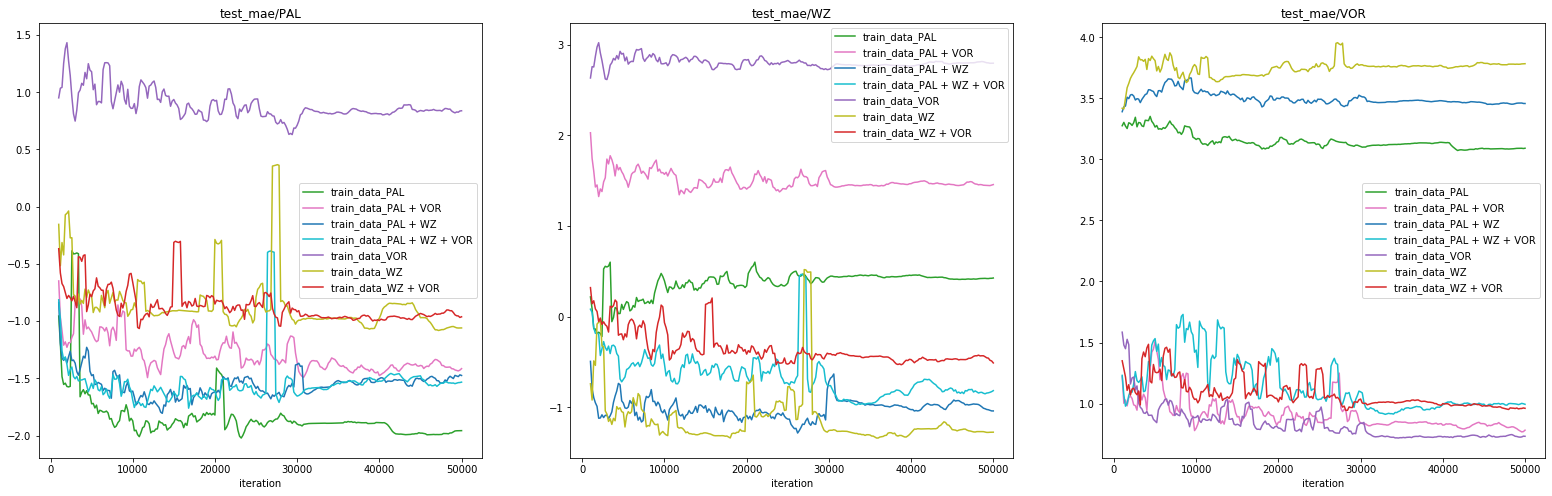

In [18]:
show_research(results.df, layout=['test_mae/PAL', 'test_mae/WZ', 'test_mae/VOR'], 
              average_repetitions=True, color=list(mcolors.TABLEAU_COLORS.keys()), 
              log_scale=True, rolling_window=5, scale=(9, 8))

In [22]:
print_results(results.df, 'test_mae/PAL', False, ascending=True,
              sort_by='test_mae_mean', n_last=10)

,test_mae_2,test_mae_0,test_mae_1,test_mae_mean,test_mae_std
train_data_PAL,0.123491,0.151346,0.153418,0.142752,0.013645
train_data_PAL + WZ,0.186201,0.197486,0.250125,0.211271,0.027858
train_data_PAL + WZ + VOR,0.223055,0.195057,0.230055,0.216056,0.015121
train_data_PAL + VOR,0.239554,0.274123,0.249125,0.254268,0.014574
train_data_WZ,0.429969,0.328977,0.300550,0.353165,0.055535
train_data_WZ + VOR,0.391829,0.425755,0.343547,0.387044,0.033732
train_data_VOR,2.306050,1.920434,2.661524,2.296003,0.302632


In [23]:
print_results(results.df, 'test_mae/WZ', False, ascending=True,
              sort_by='test_mae_mean', n_last=10)

,test_mae_2,test_mae_0,test_mae_1,test_mae_mean,test_mae_std
train_data_WZ,0.241351,0.336840,0.263706,0.280633,0.040779
train_data_PAL + WZ,0.230933,0.527514,0.289399,0.349282,0.128269
train_data_PAL + WZ + VOR,0.457920,0.329456,0.530346,0.439241,0.083070
train_data_WZ + VOR,0.629173,0.455391,0.610156,0.564907,0.077827
train_data_PAL,1.529638,1.813069,1.308618,1.550442,0.206466
train_data_PAL + VOR,4.419988,4.009205,4.689055,4.372749,0.279550
train_data_VOR,16.522962,16.132713,16.480275,16.378650,0.174775


In [25]:
print_results(results.df, 'test_mae/VOR', False, ascending=True,
              sort_by='test_mae_mean', n_last=10)

,test_mae_2,test_mae_0,test_mae_1,test_mae_mean,test_mae_std
train_data_VOR,2.058938,2.001779,2.142130,2.067615,0.057626
train_data_PAL + VOR,2.251031,2.447894,2.103970,2.267631,0.140896
train_data_WZ + VOR,2.846633,2.469238,2.490824,2.602231,0.173042
train_data_PAL + WZ + VOR,2.923357,2.417415,2.621473,2.654081,0.207833
train_data_PAL,24.813243,19.831514,22.098229,22.247662,2.036525
train_data_PAL + WZ,32.172124,30.840327,32.381195,31.797882,0.682452
train_data_WZ,42.990056,48.557685,41.079715,44.209152,3.172239


### Conclusion

- Any model can perform relatively well on PAL and WZ datasets.
- Models trained on PAL or WZ datasets can not predict well on VOR.